This notebook is used to play around the JAX-CANOAK model.

# Load the necessary libraries

In [ ]:
# # TODO: A more generic way is needed here to load the path
# import sys
# sys.path.append(
#     "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
# )

In [2]:
import jax
import equinox as eqx

from functools import partial

import numpy as np
import jax.numpy as jnp

from jax_canoak.subjects import initialize_met, initialize_parameters
from jax_canoak.subjects import initialize_profile, initialize_model_states
from jax_canoak.physics.carbon_fluxes import angle, leaf_angle
from jax_canoak.physics.energy_fluxes import diffuse_direct_radiation
from jax_canoak.physics import generate_night_mask, generate_turbulence_mask
from jax_canoak.models import canoak

# import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import plot_daily


# from jax_canoak.shared_utilities.plot import plot_veg_temp, plot_dij
# from jax_canoak.shared_utilities.plot import plot_ir, plot_rad, plot_prof2

jax.config.update("jax_enable_x64", True)

# Model parameters and settings

In [3]:
time_zone = -8
latitude = 38.0991538
longitude = -121.49933
stomata = 2
hypo_amphi = 1
veg_ht = 0.8
leafangle = 1
n_can_layers = 50
meas_ht = 5.0
n_hr_per_day = 48
lai = 5.0

niter = 15

# Load and set the model forcings
TODO: this needs more fine tuning. One mother function is desired to take care of these lines

In [4]:
f_forcing = "./src/jax_canoak/shared_utilities/forcings/AlfBouldinMetInput.csv"
forcing_data = np.loadtxt(f_forcing, delimiter=",")
forcing_data = jnp.array(forcing_data)
n_time = forcing_data.shape[0]
zl0 = jnp.zeros(n_time)
forcing_data = jnp.concatenate([forcing_data, jnp.ones([n_time, 1]) * lai], axis=1)
met = initialize_met(forcing_data, n_time, zl0)

# Create the model parameter instance

In [5]:
para = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    hypo_amphi=hypo_amphi,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    meas_ht=meas_ht,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
)

# Generate or read the dispersion matrix
TODO:  Likewise, one function is desired here.

In [6]:
# dij = disp_canveg(para, timemax=5000.0)
dij = np.loadtxt("./src/jax_canoak//models/Dij_Alfalfa.csv", delimiter=",")
dij = jnp.array(dij)

# Initialize profiles of scalars/sources/sinks

In [7]:
prof = initialize_profile(met, para)

# Initialize model states

In [8]:
soil, quantum, nir, ir, qin, rnet, sun, shade, veg, lai = initialize_model_states(
    met, para
)
soil_mtime = int(soil.mtime)  # convert it to integer instead from jax array

# Compute sun angles

In [9]:
sun_ang = angle(para.lat_deg, para.long_deg, para.time_zone, met.day, met.hhour)

# Compute leaf angles

In [10]:
leaf_ang = leaf_angle(sun_ang, para, lai)

# Compute direct and diffuse radiations

In [11]:
ratrad, par_beam, par_diffuse, nir_beam, nir_diffuse = diffuse_direct_radiation(
    sun_ang.sin_beta, met.rglobal, met.parin, met.P_kPa
)
quantum = eqx.tree_at(
    lambda t: (t.inbeam, t.indiffuse), quantum, (par_beam, par_diffuse)
)
nir = eqx.tree_at(lambda t: (t.inbeam, t.indiffuse), nir, (nir_beam, nir_diffuse))

# Generate masks for matrix calculations

In [12]:
# Night mask
mask_night_hashable = generate_night_mask(sun_ang)
# Turbulence mask
mask_turbulence_hashable = generate_turbulence_mask(para, met, prof)

# Test the time of jitted function

In [15]:
initials = [
    prof,
    dij,
    lai,
    sun_ang,
    leaf_ang,
    quantum,
    nir,
    ir,
    qin,
    ratrad,
    sun,
    shade,
    veg,
    soil,
    mask_night_hashable,
    mask_turbulence_hashable,
    int(soil_mtime),
    niter,
]

In [14]:
# without jit
%timeit canoak(para, met, *initials)

3.82 s ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# with jit, we get speedup to 60 times!
canoak_jit = eqx.filter_jit(canoak)
%timeit canoak_jit(para, met, *initials)

490 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Run CANOAK!

In [29]:
# Let's use a jitted version
canoak_jit = eqx.filter_jit(canoak)
met1, prof1, ir1, qin1, sun1, shade1, soil1, veg1 = canoak_jit(para, met, *initials)

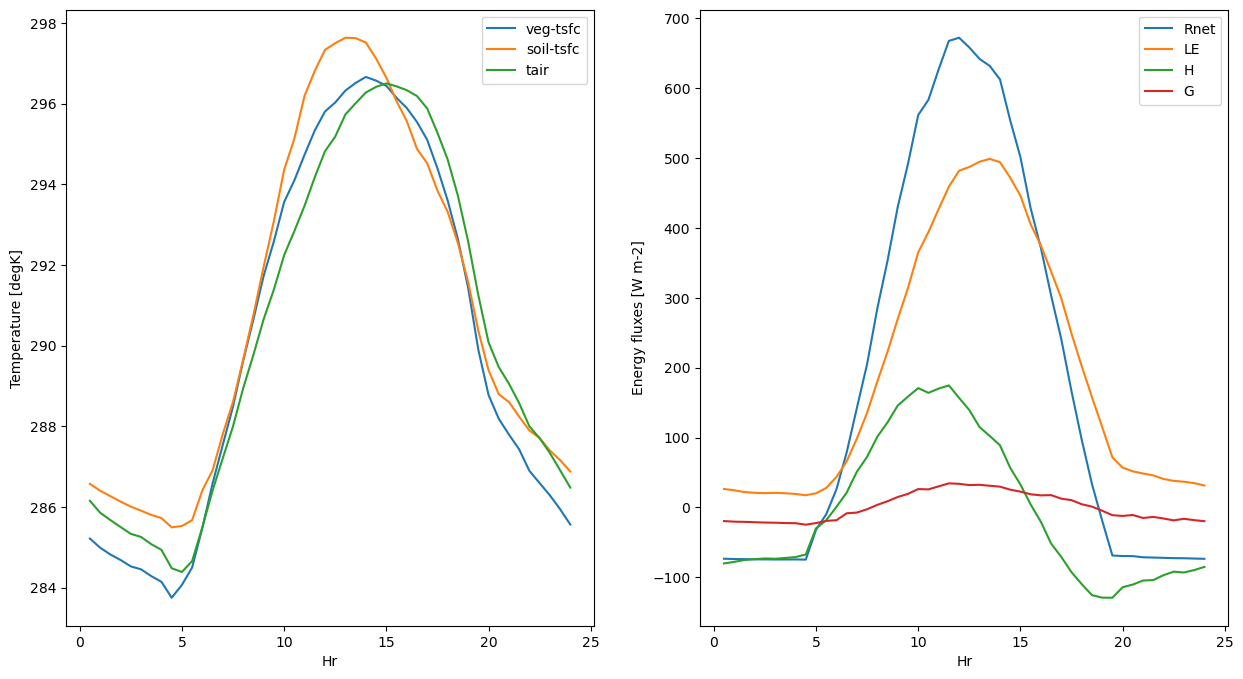

In [30]:
#
plot_daily(met1, soil1, veg1, para)

# Now, let's do some sensitivity analysis for fun!

The first try: how is the soil surface temperature sensitive to the atmospheric forcing?
To do that, we need to create a seperate jittable function that only outputs soil surface temperature.

In [19]:
# # The following leads to a dead kernel, mostly likely due to the OOM issue
# @eqx.filter_jit
# @partial(jax.jacfwd, argnums=1)
# def canoak_soil_sfc(para, met, *args):
#     met, prof, ir, qin, sun, shade, soil, veg = canoak(
#         para, met, *args
#     )
#     return soil.sfc_temperature

# gradients = canoak_soil_sfc(para, met, *initials)

: 

: 

In [17]:
# # The following leads to a dead kernel as well
# Let's try doing sensitivity analysis on one output
@eqx.filter_jit
@partial(jax.grad, argnums=1)
def canoak_soil_sfc(para, met, *args):
    met, prof, ir, qin, sun, shade, soil, veg = canoak(para, met, *args)
    return soil.sfc_temperature[0]


gradients = canoak_soil_sfc(para, met, *initials)